# Predicting Diatom production rate with Histogram-based Gradient Boosting Regression Tree

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import r_regression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

import random

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi

from sklearn.inspection import permutation_importance


## Datasets Preparation

In [2]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, name, inputs_names):

    x = np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y))
    y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter))

    dayofyear = np.tile(np.arange(0,len(dataset.time_counter)//len(np.unique(dataset.time_counter.dt.year))), len(np.unique(dataset.time_counter.dt.year)))

    inputs = []
    
    if 'Day_of_year' in inputs_names:   
        for i in inputs_names[0:inputs_names.index('Day_of_year')]:
            inputs.append(dataset[i].to_numpy().flatten())  

        inputs.append(np.repeat(dayofyear, len(dataset.x)*len(dataset.y)))

        for i in inputs_names[inputs_names.index('Day_of_year')+1:]:
            inputs.append(dataset[i].to_numpy().flatten()) 

    else:        
        for i in inputs_names:
            inputs.append(dataset[i].to_numpy().flatten())

    inputs = np.array(inputs)

    targets = np.ravel(dataset[name])
    
    indx = np.where(np.isfinite(targets) & (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,indx[0]]
    targets = targets[indx[0]]

    inputs = inputs.transpose()

    return(inputs, targets, indx)


## Regressor

In [3]:
def regressor (inputs, targets, n_bins, drivers, spatial, inputs_names):

    if spatial == []:
        model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
            transformers=[('drivers', StandardScaler(), np.arange(0,len(drivers)))], remainder='passthrough'),
            HistGradientBoostingRegressor(categorical_features=[len(drivers)])),
            transformer=StandardScaler())

    else:
        model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
        transformers=[('drivers', StandardScaler(), np.arange(0,len(drivers))), 
            ('spatial', KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='quantile'), np.arange(inputs_names.index(spatial[0]),inputs_names.index(spatial[-1])+1))],
            remainder='passthrough'),
        HistGradientBoostingRegressor(categorical_features=np.arange(inputs_names.index(spatial[0]),len(inputs_names)))),
        transformer=StandardScaler())
    
    regr = model.fit(inputs,targets)

    r_inputs = np.round(r_regression(inputs,targets),2)

    return(regr, r_inputs)


## Importance

In [4]:
def importance(dataset, regr, name, inputs_names):

    inputs, targets, _ = datasets_preparation(dataset, name, inputs_names)

    importances_all = permutation_importance(regr, inputs, targets, n_repeats=5, scoring=('r2','neg_root_mean_squared_error'))
    inputs_names2 = ['SWR', 'LWR', 'TP', 'AP', 'AT', 'SH', 'WS', 'Lat', 'Lon', 'Day']

    sorted_importances_idx = importances_all['r2'].importances_mean.argsort()
    x = []
    for i in range (0, len(inputs_names2)):
        x.append(inputs_names2[sorted_importances_idx[i]])

    r_importance = pd.Series(importances_all['r2'].importances_mean[sorted_importances_idx], index=x)
   
    sorted_importances_idx = importances_all['neg_root_mean_squared_error'].importances_mean.argsort()
    x = []
    for i in range (0, len(inputs_names2)):
        x.append(inputs_names2[sorted_importances_idx[i]])

    rms_importance = pd.Series(importances_all['neg_root_mean_squared_error'].importances_mean[sorted_importances_idx], index=x)

    return(r_importance, rms_importance)
   

## Plotting (Regions)

In [5]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)
    

## Initiation

In [6]:
name = 'Diatom_Production_Rate'
units = '[mmol N / $m^2$ / $s$]'
category = 'Production rates'

filename = '/data/ibougoudis/MOAD/files/inputs/jan_mar.nc'

drivers =  ['Summation_of_solar_radiation', 'Summation_of_longwave_radiation', 'Mean_precipitation', 'Mean_pressure', 'Mean_air_temperature', 'Mean_specific_humidity', 'Mean_wind_speed']
spatial = ['Latitude', 'Longitude']
day_input = ['Day_of_year']
inputs_names = drivers + spatial + day_input

n_bins = 255

if filename[35:42] == 'jan_mar': # 75 days, 1st period
    period = '(16 Jan - 31 Mar)'
    id = '1'
    months = ['January', 'February', 'March']

elif filename[35:42] == 'jan_apr': # 120 days, 2nd period
    period = '(01 Jan - 30 Apr)'
    id = '2'
    months = ['January', 'February', 'March', 'April']

elif filename[35:42] == 'feb_apr': # 75 days, 3rd period
    period = '(15 Feb - 30 Apr)'
    id = '3'
    months = ['February', 'March', 'April']

elif filename[35:42] == 'apr_jun': # 76 days, 4th period
    period = '(16 Apr - 30 Jun)'
    id = '4'
    months = ['April', 'May', 'June']

elif filename[35:42] == 'may_sep': # 153 days, 5th period
    period = '(01 May - 30 Sep)'
    id = '5'
    months = ['May', 'June', 'July', 'August', 'September']
   
ds = xr.open_dataset(filename)
ds0 = ds # For the regional plot

# Low resolution

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))


## Regions

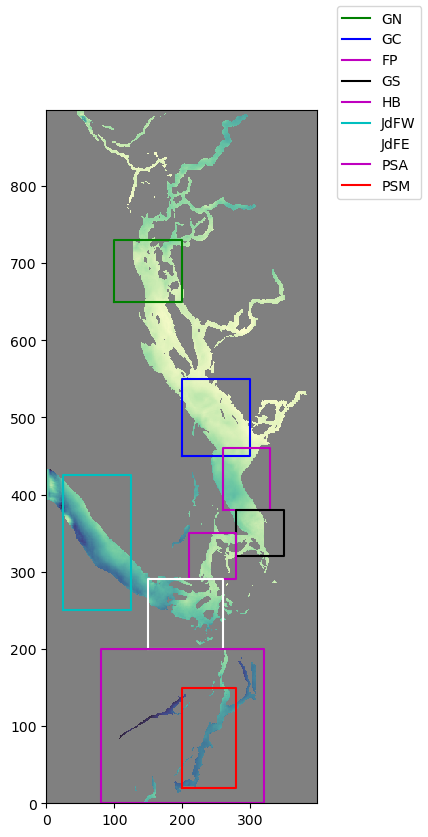

In [7]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(ds0[name][0], cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['GN','GC','FP','GS', 'HB', 'JdFW', 'JdFE', 'PSA', 'PSM']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(ds0.y),len(ds0.x)),np.nan)
for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])

# Low resolution

# temp = []
# for i in boxes:

#     temp.append([x//5 for x in i])

# boxes = temp

# regions0 = regions0.isel(y=(np.arange(regions0.y[0], regions0.y[-1], 5)), 
#     x=(np.arange(regions0.x[0], regions0.x[-1], 5)))


## Training

In [8]:
dataset = ds.sel(time_counter = slice('2007', '2020'))

labels = np.unique(dataset.time_counter.dt.strftime('%d %b'))
indx_labels = np.argsort(pd.to_datetime(labels, format='%d %b'))
labels = labels[indx_labels]

inputs, targets, indx = datasets_preparation(dataset, name, inputs_names)

regr, r_inputs = regressor(inputs, targets, n_bins, drivers, spatial, inputs_names)

print('Metrics between input features and '+name)
temp = pd.DataFrame(r_inputs, index=inputs_names, columns=[period])
display(temp)

predictions = regr.predict(inputs)


Metrics between input features and Diatom_Production_Rate


,(16 Jan - 31 Mar)
Summation_of_solar_radiation,0.78
Summation_of_longwave_radiation,-0.41
Mean_precipitation,-0.30
Mean_pressure,0.18
Mean_air_temperature,0.03
Mean_specific_humidity,-0.14
Mean_wind_speed,-0.27
Latitude,0.10
Longitude,-0.00
Day_of_year,0.57


## Calculations

In [9]:
dataset = ds.sel(time_counter = slice('2021', '2024'))
r_importance, rms_importance = importance(dataset, regr, name, inputs_names)


## Single

In [10]:
test_s = []
names = []

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_3_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('current')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_5_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- TP')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_7_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- SWR')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_9_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- Lat')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_10_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- Day')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_8_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- Lon')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_4_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- WS')

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_6_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_s.append(dill.load(f))
names.append('- AT')


## Boxes

In [11]:
test_b = []

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_0_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_4_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_7_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_9_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_1_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_8_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_2_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))

path = '/data/ibougoudis/MOAD/files/results/' + name + '/bootstraps/' + name[0:4].lower() + '_pr_hist1_boxes_3_boot_100/'
with open(path + 'test_metrics.pkl', 'rb') as f:
    test_b.append(dill.load(f))


## Calculations

In [12]:
r_s = np.zeros((len(names), len(boxnames)))
r_b = np.zeros((len(names), len(boxnames)))

rms_s = np.zeros((len(names), len(boxnames)))
rms_b = np.zeros((len(names), len(boxnames)))

for i in range (0, len(names)):

    r_s[i,:] = np.nanmean(test_s[i][3], axis=0)
    r_b[i,:] = np.nanmean(test_b[i][3], axis=0)

    rms_s[i,:] = np.nanmean(test_s[i][1], axis=0)
    rms_b[i,:] = np.nanmean(test_b[i][1], axis=0)

## Radar Plot (R Testing no Seasonality)

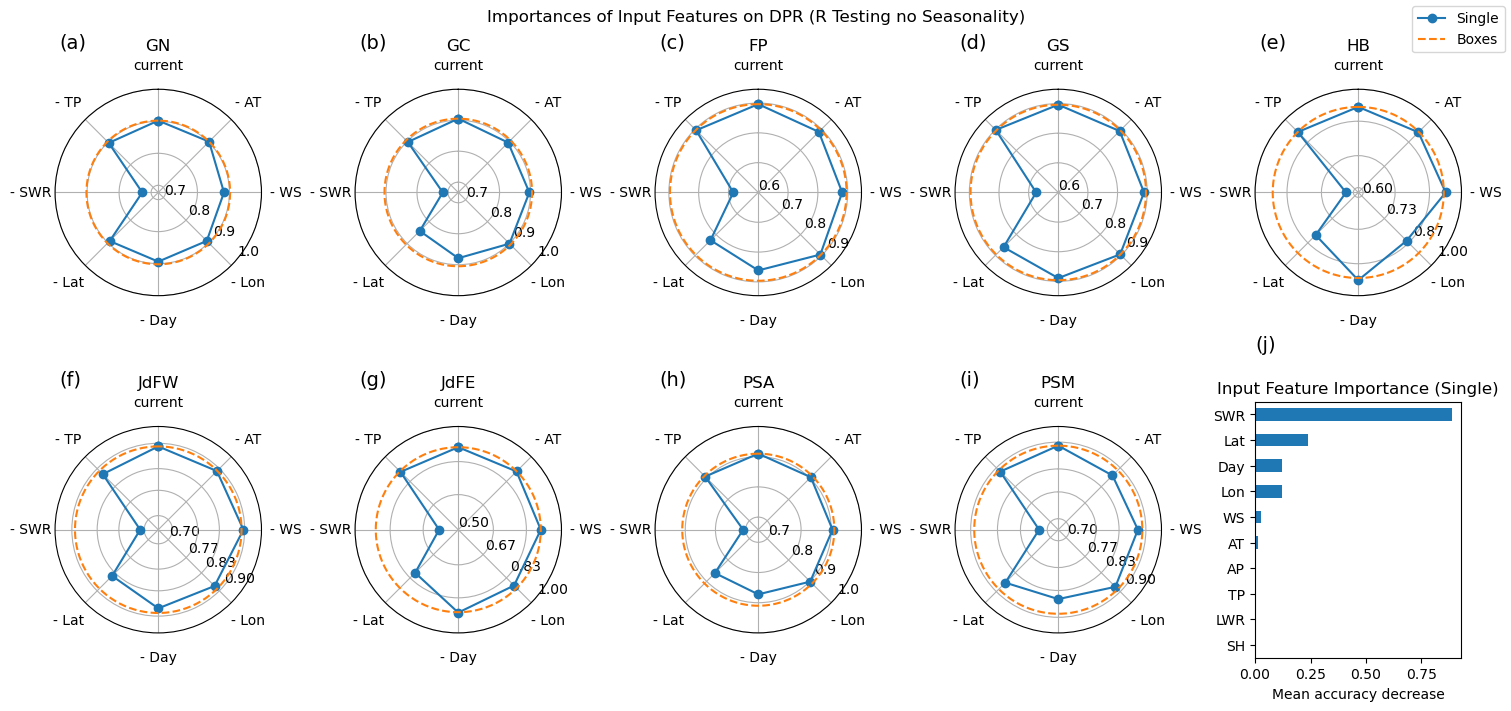

In [13]:
labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

k,l = 0,0
fig, ax = plt.subplots(2, 5, figsize=(15, 7), layout='constrained', subplot_kw={'projection': 'polar'})

for i in range (0, len(boxes)):

    theta = np.arange(len(names) + 1) / float(len(names)) * 2 * np.pi

    values = np.append(r_s[:,i], r_s[:,i][0])
    values2 = np.append(r_b[:,i], r_b[:,i][0])

    ax[k,l].plot(theta, values, marker='o', label ='Single')
    # ax[k,l].plot(theta, values2, marker='o', label = 'Boxes')
    ax[k,l].plot(np.linspace(0, 2*np.pi, 100), np.full(100, values[0]), ls = '--')

    ax[k,l].annotate(labels[i], (0.02, 1.2), xycoords='axes fraction', fontsize=14)

    ax[k,l].set_theta_zero_location('N')
    ax[k,l].set_rmax(np.maximum(np.max(values)+0.05, np.max(values)+0.05))
    ax[k,l].set_rmin(np.minimum(np.min(values)-0.05, np.min(values)-0.05)) 
    ax[k,l].set_rticks(np.round(np.linspace(np.round(np.minimum(np.min(values)-0.05, np.min(values)-0.05),1), np.round(np.maximum(np.max(values)+0.05, np.max(values)+0.05),1), 4), 2))

    ax[k,l].set_rlabel_position(230)
    ax[k,l].tick_params(pad = 7)

    ax[k,l].set_xticks(theta[:-1], names)
    ax[k,l].set_title(boxnames[i], x=0.50, y=1.15)

    l=l+1
    if l==5:
        l=0
        k=k+1

fig.legend(['Single', 'Boxes'])
fig.suptitle('Importances of Input Features on DPR (R Testing no Seasonality)')

ax[k,l].remove()
ax[k,l] = fig.add_subplot(2,5,10)

ax[k,l].annotate('(j)', (0.00, 1.2), xycoords='axes fraction', fontsize=14)
r_importance.plot.barh(ax=ax[k,l])

ax[k, l].set_title('Input Feature Importance (Single)')
ax[k,l].set_xlabel('Mean accuracy decrease')

plt.show()


## Radar Plot (RMS Testing)

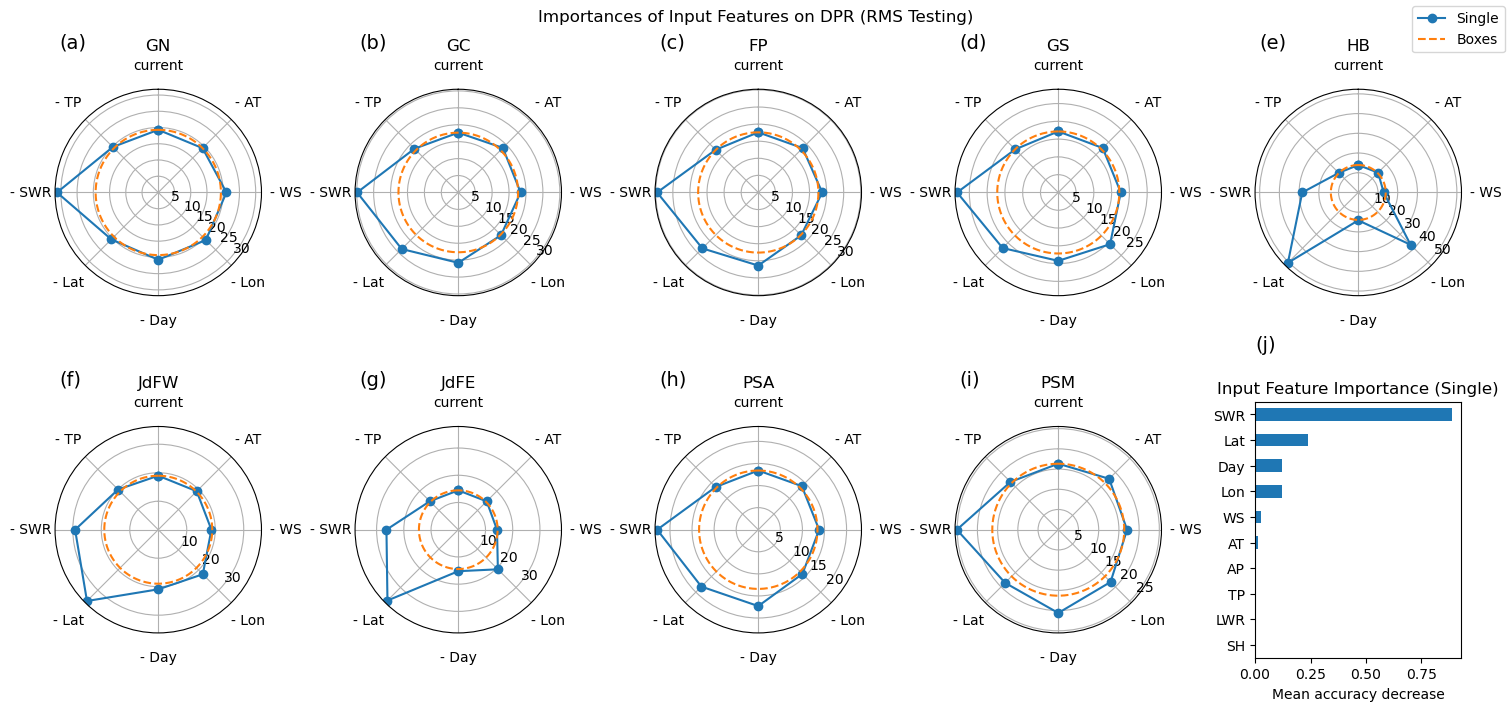

In [14]:
labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

k,l = 0,0
fig, ax = plt.subplots(2, 5, figsize=(15, 7), layout='constrained', subplot_kw={'projection': 'polar'})

for i in range (0, len(boxes)):

    theta = np.arange(len(names) + 1) / float(len(names)) * 2 * np.pi

    values = np.append(rms_s[:,i], rms_s[:,i][0])
    values2 = np.append(rms_b[:,i], rms_b[:,i][0])

    ax[k,l].plot(theta, values, marker='o', label ='Single')
    # ax[k,l].plot(theta, values2, marker='o', label = 'Boxes')
    ax[k,l].plot(np.linspace(0, 2*np.pi, 100), np.full(100, values[0]), ls = '--')

    ax[k,l].annotate(labels[i], (0.02, 1.2), xycoords='axes fraction', fontsize=14)

    ax[k,l].set_theta_zero_location('N')
    # ax[k,l].set_rmax(np.maximum(np.max(values)+0.05, np.max(values2)+0.05))
    # ax[k,l].set_rmin(np.minimum(np.min(values)-0.05, np.min(values2)-0.05)) 
    # ax[k,l].set_rticks(np.round(np.linspace(np.round(np.minimum(np.min(values)-0.05, np.min(values2)-0.05),1), np.round(np.maximum(np.max(values)+0.05, np.max(values2)+0.05),1), 4), 2))

    ax[k,l].set_rlabel_position(230)
    ax[k,l].tick_params(pad = 7)

    ax[k,l].set_xticks(theta[:-1], names)
    ax[k,l].set_title(boxnames[i], x=0.50, y=1.15)

    l=l+1
    if l==5:
        l=0
        k=k+1

fig.legend(['Single', 'Boxes'])
fig.suptitle('Importances of Input Features on DPR (RMS Testing)')

ax[k,l].remove()
ax[k,l] = fig.add_subplot(2,5,10)

ax[k,l].annotate('(j)', (0.00, 1.2), xycoords='axes fraction', fontsize=14)
r_importance.plot.barh(ax=ax[k,l])

ax[k, l].set_title('Input Feature Importance (Single)')
ax[k,l].set_xlabel('Mean accuracy decrease')

plt.show()


## Saving

In [ ]:
path = '/data/ibougoudis/MOAD/files/results/' + name + '/importance/' + name[0:4].lower() + '_pr_hist' + id + '_boxes3/'

os.makedirs(path, exist_ok=True)
with lzma.open(path + 'regr_all.xz', 'wb') as f:   
    dill.dump(regr, f)

with open(path + 'r_inputs.pkl', 'wb') as f:
    dill.dump(r_inputs, f)

with open(path + 'train_metrics.pkl', 'wb') as f:
    dill.dump([r_train,rms_train,slope_train,r_train_season,slope_train_season,season.transpose()], f)

with open(path + 'test_metrics.pkl', 'wb') as f:
    dill.dump([r_test,rms_test,slope_test,r_test_season,slope_test_season,targets_sum,predictions_sum,targets_mean,predictions_mean,targets_diff,predictions_diff,rss], f)

file_creation(path, targets_all, 'Targets')
file_creation(path, predictions_all, 'Predictions')
file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')

with open(path + 'readme.txt', 'w') as f:
    f.write ('name: ' + name)
    f.write('\n')
    f.write('period: ' + filename[35:42])
    f.write ('\n')
    f.write ('input_features: ')
    f.write (str([i for i in inputs_names]))
    f.write ('\n')
    f.write('n_bins: ' + str(n_bins))
    f.write ('\n')
